In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True,

## Downloading and subsetting data

In [4]:
os.chdir("G:\\142A_Project")
song_attributes = pd.read_csv("song-attributes.txt", delimiter="\t", header=None, encoding='ISO-8859-1')
song_attributes.columns = ['song_id', 'artist_id', 'album_id', 'genre_id']

genre_hierarchy = pd.read_csv("genre-hierarchy.txt", delimiter="\t", encoding='ISO-8859-1', header=None)
genre_hierarchy.columns = ['genre_id', 'parent_genre_id', 'level', 'genre_name']

#### Load Train and test
data_train_1 = pd.read_csv("train_0.txt", delimiter="\t", encoding='ISO-8859-1', header=None)
data_train_1.columns = ['user_id', 'song_id', 'rating']
mergedTrain_1 = pd.merge(data_train_1, song_attributes, on=['song_id'], how='left')
mergedTrain_3 = pd.merge(mergedTrain_1, genre_hierarchy, on=['genre_id'], how='left')

data_test_1 = pd.read_csv("test_0.txt", delimiter="\t", encoding='ISO-8859-1', header=None)
data_test_1.columns = ['user_id', 'song_id', 'rating']
mergedTest_1 = pd.merge(data_test_1, song_attributes, on=['song_id'], how='left')
mergedTest_3 = pd.merge(mergedTest_1, genre_hierarchy, on=['genre_id'], how='left')

mergedTrain_2 = mergedTrain_3
mergedTest_2 = mergedTest_3

# here we take the first r1 entries from our training data and then we randomly sample
# n1 entries from the r1 entries. Due to the way our testing and training data was organized
# it might be necessary to make this process more intuitive.
#r1 = 1000000
#mergedTrain_2 = mergedTrain_3.loc[1:r1]
#n1 = 100000
#mergedTrain_2 = mergedTrain_2.sample(n1)


#r2 = 1000000
#mergedTest_2 = mergedTest_3.loc[1:r2]
#n2 = 100000
#mergedTest_2 = mergedTest_2.sample(n1)

n=100000
mergedTrain_2 = mergedTrain_3.loc[1:n]
mergedTest_2 = mergedTest_3.loc[1:2140]

## Adding columns of mean individual artist ratings and user ratings
Below we use groupby to create mean ratings for individual artists_ids, individual song_ids and individual user_ids. We then left merge them back into our data so each user id has a corresponding mean rating of each of these variables. We then remove all categorical or "meaningless" variables. By removing all categorical variables and replacing them with means we remove noise that meaningless numbers would give to our model. Genre and related metrics were too sparse of predictors to use so we did not include them in the model. 

In [5]:
## train
X_Train_1 = mergedTrain_2.drop(
    labels=['genre_id', 'album_id', 'parent_genre_id', 'genre_name', 'level'],
    axis=1)
##Groupby().mean creates means for each individual entry we specify.
# find mean rating for each user id
X_Train_GroupUser = X_Train_1.groupby('user_id', as_index=False)['rating'].mean()
X_Train_GroupUser.columns = ['user_id', 'mean_user_rating']
X_Train_1 = pd.merge(X_Train_1, X_Train_GroupUser, on=['user_id'], how='left')
#find mean rating for each artist id
X_Train_GroupArtist = X_Train_1.groupby('artist_id', as_index=False)['rating'].mean()
X_Train_GroupArtist.columns = ['artist_id', 'mean_artist_rating']
X_Train_1 = pd.merge(X_Train_1, X_Train_GroupArtist, on=['artist_id'], how='left')
#find mean rating for each song id
X_Train_GroupSong = X_Train_1.groupby('song_id', as_index=False)['rating'].mean()
X_Train_GroupSong.columns = ['song_id', 'mean_song_rating']
X_Train_1 = pd.merge(X_Train_1, X_Train_GroupSong, on=['song_id'], how='left')
#drop all categorical variables as they are numbers with no mathematical meaning, 
#we also drop rating from X since it is our dependent variable
X_Train_1 = X_Train_1.drop(labels=['user_id','song_id','rating','artist_id'], axis=1)
X_Train_1_df = X_Train_1
print(X_Train_1.columns.values)
Y_Train_1 = mergedTrain_2.drop(mergedTrain_2.columns.difference(['rating']), axis=1)
X_Train_1 = np.asarray(X_Train_1)
Y_Train_1 = np.asarray(Y_Train_1).reshape(-1, 1)




## test, we do the same process as above for our training 
X_Test_1 = mergedTest_2.drop(
    labels=[ 'genre_id', 'album_id', 'parent_genre_id', 'genre_name', 'level'],
    axis=1)
X_Test_GroupUser = X_Test_1.groupby('user_id', as_index=False)['rating'].mean()
X_Test_GroupUser.columns = ['user_id', 'mean_user_rating']
X_Test_1 = pd.merge(X_Test_1, X_Test_GroupUser, on=['user_id'], how='left')

X_Test_GroupArtist = X_Test_1.groupby('artist_id', as_index=False)['rating'].mean()
X_Test_GroupArtist.columns = ['artist_id', 'mean_artist_rating']
X_Test_1 = pd.merge(X_Test_1, X_Test_GroupArtist, on=['artist_id'], how='left')

X_Test_GroupSong = X_Test_1.groupby('song_id', as_index=False)['rating'].mean()
X_Test_GroupSong.columns = ['song_id', 'mean_song_rating']
X_Test_1 = pd.merge(X_Test_1, X_Test_GroupSong, on=['song_id'], how='left')

X_Test_1 = X_Test_1.drop(labels=['user_id','song_id','rating','artist_id'], axis=1)
X_Test_1_df = X_Test_1
print(X_Test_1.columns.values)

Y_Test_1 = mergedTest_2.drop(mergedTest_2.columns.difference(['rating']), axis=1)
X_Test_1 = np.asarray(X_Test_1)
Y_Test_1 = np.asarray(Y_Test_1).reshape(-1, 1)


## standardizing data
Y_Train_1 = Y_Train_1.ravel()
Y_Test_1 = Y_Test_1.ravel()



scaler = StandardScaler()
scaler.fit(X_Train_1)

X_Train_1 = scaler.transform(X_Train_1)
X_Test_1 = scaler.transform(X_Test_1)

['mean_user_rating' 'mean_artist_rating' 'mean_song_rating']
['mean_user_rating' 'mean_artist_rating' 'mean_song_rating']


## Plotting accuracy for K for uniform and distance individually
We now will plot the cross validated scores we get for each value of k. We will do this for both uniform and distance weight parameters. This is done to check if the optimized parameters we will get from the grid search make sense or if we need to expand our range of k values. If we see the graph is hitting maximum and further k values do not increase accuracy we do not need to expand our range of k values to test. However, if the maximum is not reached we will need to expand our range of k values until we reach a k value that creates a maximum accuracy. 

[0.54931, 0.55838, 0.56447, 0.56816, 0.56989, 0.5719400000000001, 0.5733699999999999, 0.5746200000000001, 0.5751999999999999, 0.5757399999999999, 0.5765499999999999, 0.5773500000000001, 0.5779499999999999, 0.57857, 0.5795399999999999, 0.5805100000000001, 0.5805800000000001, 0.5811499999999999, 0.58156, 0.5817899999999999, 0.58185, 0.58189, 0.58195, 0.5822700000000001, 0.5822799999999999, 0.5827899999999999, 0.58293, 0.5831200000000001, 0.58311, 0.58296, 0.5831799999999999, 0.58373, 0.58359, 0.5837399999999999, 0.58409]


Text(0.5, 1.0, 'Fig 1')

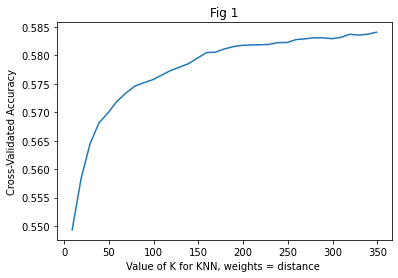

In [16]:
knn = KNeighborsClassifier()
#k_range = range(1, 100)
k_range = list(range(9, 359,10))
# list of scores from k_range
k_scores = []

# 1. we will loop through reasonable values of k
for k in k_range:
    # 2. run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k,weights='distance')
    # 3. obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn, X_Train_1, Y_Train_1, cv=10, scoring='accuracy')
    # 4. append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())
print(k_scores)

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN, weights = distance ')
plt.ylabel('Cross-Validated Accuracy')
plt.title("Fig 1")

[0.56836, 0.5858899999999999, 0.5952300000000001, 0.59962, 0.60211, 0.6042, 0.6068800000000001, 0.60774, 0.60865, 0.61023, 0.61123, 0.61216, 0.61249, 0.61295, 0.61331, 0.61444, 0.6144900000000001, 0.61453, 0.6146900000000001, 0.61487, 0.61497, 0.6153899999999999, 0.61468, 0.61469, 0.61521, 0.61528, 0.61498, 0.6152700000000001, 0.61607, 0.61636, 0.61706, 0.6171900000000001, 0.61764, 0.61771, 0.6182599999999999]


Text(0.5, 1.0, 'Fig 2')

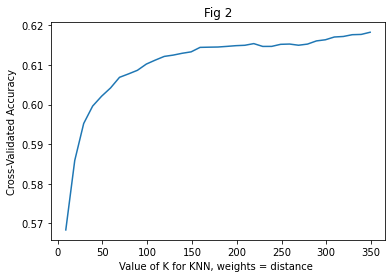

In [17]:
knn = KNeighborsClassifier()
#k_range = range(1, 100)
k_range = list(range(9, 359,10))
# list of scores from k_range
k_scores = []

# 1. we will loop through reasonable values of k
for k in k_range:
    # 2. run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k,weights='uniform')
    # 3. obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn, X_Train_1, Y_Train_1, cv=10, scoring='accuracy')
    # 4. append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())
print(k_scores)

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN, weights = distance ')
plt.ylabel('Cross-Validated Accuracy')
plt.title("Fig 2")

Text(0.5, 1.0, 'Fig 3')

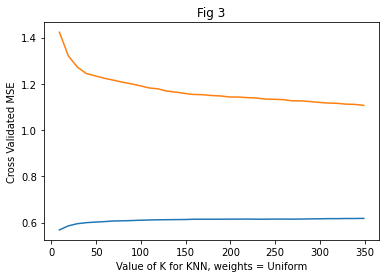

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
knn = KNeighborsClassifier()
#k_range = range(1, 100)
k_range = list(range(9, 359,10))
# list of scores from k_range
k_scores = []
mse = []
# 1. we will loop through reasonable values of k
for k in k_range:
    # 2. run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k,weights='uniform',n_jobs=-1)
    y_pred = cross_val_predict(knn, X_Train_1, Y_Train_1, cv=10)
    # 3. obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn, X_Train_1, Y_Train_1, cv=10, scoring='accuracy')
    # 4. append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())
    mse.append(mean_squared_error(Y_Train_1,y_pred))
    

#plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN, weights = Uniform')
plt.ylabel('Cross-Validated Accuracy')
plt.plot(k_range, mse)
plt.xlabel('Value of K for KNN, weights = Uniform')
plt.ylabel('Cross Validated MSE')
plt.title("Fig 3")

Text(0.5, 1.0, 'Fig 4')

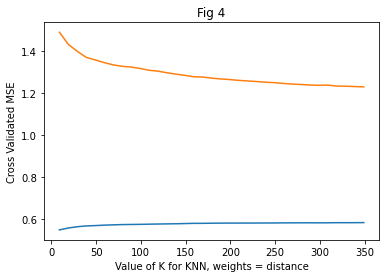

In [19]:
knn = KNeighborsClassifier()
#k_range = range(1, 100)
k_range = list(range(9, 359,10))
# list of scores from k_range
k_scores = []
mse = []
# 1. we will loop through reasonable values of k
for k in k_range:
    # 2. run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k,weights='distance',n_jobs=-1)
    y_pred = cross_val_predict(knn, X_Train_1, Y_Train_1, cv=10)
    # 3. obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn, X_Train_1, Y_Train_1, cv=10, scoring='accuracy')
    # 4. append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())
    mse.append(mean_squared_error(Y_Train_1,y_pred))
    

#plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN, weights = distance')
plt.ylabel('Cross-Validated Accuracy')
plt.plot(k_range, mse)
plt.xlabel('Value of K for KNN, weights = distance')
plt.ylabel('Cross Validated MSE')
plt.title("Fig 4")

## Finding best parameter combinations
Fig 5

In [20]:
print("Fig 5")
knn = KNeighborsClassifier()

k_range = list(range(296, 338))
weight_options = ['uniform', 'distance']

param_grid = dict(n_neighbors=k_range, weights=weight_options)
print(param_grid)

grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False, verbose=1)

grid_search = grid.fit(X_Train_1, Y_Train_1)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'n_neighbors': [296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337], 'weights': ['uniform', 'distance']}
Fitting 10 folds for each of 84 candidates, totalling 840 fits
{'n_neighbors': 337, 'weights': 'uniform'}
0.6178899999999999


## Testing the our chosen params on test data

In [21]:
print("Fig 6")
neigh = KNeighborsClassifier(n_neighbors=337,weights='uniform')
neigh.fit(X_Train_1, Y_Train_1)
print(neigh.score(X_Test_1, Y_Test_1, sample_weight=None))


0.8495327102803738


[0.54931, 0.55838, 0.56447, 0.56816, 0.56989, 0.5719400000000001, 0.5733699999999999, 0.5746200000000001, 0.5751999999999999, 0.5757399999999999, 0.5765499999999999, 0.5773500000000001, 0.5779499999999999, 0.57857, 0.5795399999999999, 0.5805100000000001, 0.5805800000000001, 0.5811499999999999, 0.58156, 0.5817899999999999, 0.58185, 0.58189, 0.58195, 0.5822700000000001, 0.5822799999999999, 0.5827899999999999, 0.58293, 0.5831200000000001, 0.58311, 0.58296, 0.5831799999999999, 0.58373, 0.58359, 0.5837399999999999, 0.58409]


Text(0.5, 1.0, 'Fig 8: Comparing training and testing errors using model fit from training')

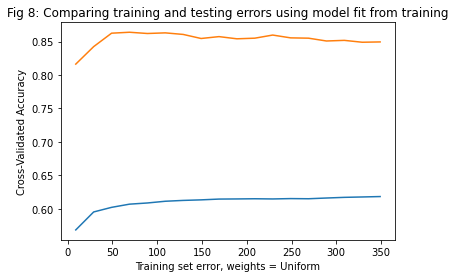

In [37]:
knn = KNeighborsClassifier()
#k_range = range(1, 100)
k_range = list(range(9, 359,20))
# list of scores from k_range
k_tr_scores = []
k_ts_scores = []
# 1. we will loop through reasonable values of k
for k in k_range:
    # 2. run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k,weights='uniform')
    knn.fit(X_Train_1, Y_Train_1)
    tr_scores = cross_val_score(knn, X_Train_1, Y_Train_1, cv=10)
    ts_scores = knn.score(X_Test_1, Y_Test_1, sample_weight=None)
    # 4. append mean of scores for k neighbors to k_scores list
    k_ts_scores.append(ts_scores.mean())
    k_tr_scores.append(tr_scores.mean())
print(k_scores)

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_tr_scores)
plt.xlabel('Training set error, weights = Uniform')
plt.ylabel('Cross-Validated Accuracy')
plt.plot(k_range, k_ts_scores)
plt.xlabel('Training set error, weights = Uniform')
plt.ylabel('Cross-Validated Accuracy')
plt.title("Fig 8: Comparing training and testing errors using model fit from training")